In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/ATACseq_250kb_bins.txt', 'data/20_80_splits_group_by_ind/20_all_samples_normalized_gaussian_smooth_CONTROLS.rds', 'data/20_80_splits_group_by_ind/80_all_samples_normalized_gaussian_smooth_CONTROLS.rds', 'data/cases_controls/cases_controls_rds_format/all_samples_normalized_gaussian_smooth_CASES.rds', "input_atac" = 'data/ATACseq_250kb_bins.txt', "input_train_data_std" = 'data/20_80_splits_group_by_ind/20_all_samples_normalized_gaussian_smooth_CONTROLS.rds', "input_test_data_std_80_controls" = 'data/20_80_splits_group_by_ind/80_all_samples_normalized_gaussian_smooth_CONTROLS.rds', "input_test_data_std_cases" = 'data/cases_controls/cases_controls_rds_format/all_samples_normalized_gaussian_smooth_CASES.rds'),
    output = list('data/ATAC_predictions_train_20_predict_80_and_cases/ATAC_pred_lasso_std_FALSE_gaussian.rds', 'Trained_models/Train_20_predict_80_and_cases_models/Lasso_models/lasso_std_FALSE_gaussian.rds', "output_pred" = 'data/ATAC_predictions_train_20_predict_80_and_cases/ATAC_pred_lasso_std_FALSE_gaussian.rds', "output_model" = 'Trained_models/Train_20_predict_80_and_cases_models/Lasso_models/lasso_std_FALSE_gaussian.rds'),
    params = list(),
    wildcards = list('FALSE', "std" = 'FALSE'),
    threads = 4,
    log = list('logs/processed_notebooks/train_20_test_80_and_cases/processed_Smooth_gaussian_10_Lasso_reg_FALSE.r.ipynb', "notebook" = 'logs/processed_notebooks/train_20_test_80_and_cases/processed_Smooth_gaussian_10_Lasso_reg_FALSE.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 150000, "disk_mb" = 24396, "tmpdir" = '/scratch/56081601', "time" = '10:00:00'),
    config = list(),
    rule = 'train_20_test_80_model_lasso_standardizing',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/ATAC_pred_models/Train_20_predict_80_and_cases_models/Lasso_regression',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression on data smoothed with Gaussian (n = 10)

In [2]:
library(tidyverse)

library(glmnet)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16



### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_controls <- read.csv("../../../data/all_samples_normalized_gaussian_smooth_CONTROLS.csv", nrows=50000)
all_samples_gaussian_controls <- readRDS(snakemake@input[["input_train_data_std"]])

In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)
colnames(ATAC) <- c("bin", "ATAC_observed")

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_gaussian_controls <- inner_join(all_samples_gaussian_controls, ATAC, by="bin")

head(all_samples_ATAC_gaussian_controls)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X692,X693,X694,X695,X696,X697,X698,X699,X700,ATAC_observed
PGDX16581P,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5866651
PGDX16581P,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.1996134
PGDX16581P,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5968816
PGDX16581P,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2905764
PGDX16581P,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2319729
PGDX16581P,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2262170


In [5]:
ATAC_val <- all_samples_ATAC_gaussian_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_gaussian_controls %>% select(sample, bin)
all_samples_ATAC_gaussian_controls = all_samples_ATAC_gaussian_controls %>% select(-c(ATAC_observed, sample, bin))

## Finding the best lambda

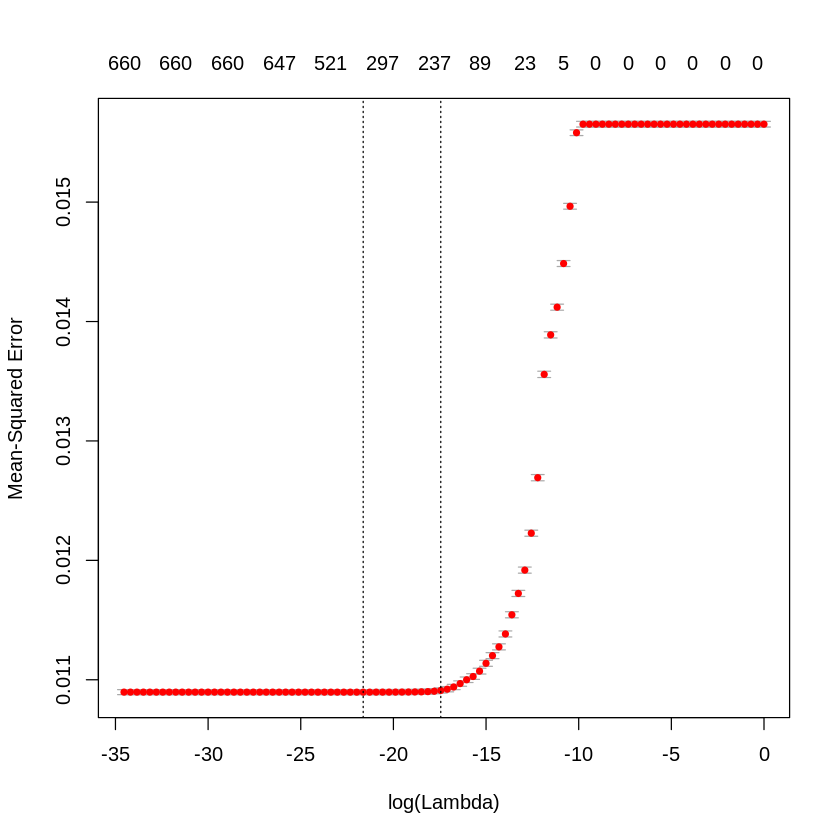

In [6]:
set.seed(0)
#X==predictor
#y==response

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()
#head(X)

lambdas_to_try <- 10^seq(-15, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0


lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = FALSE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [7]:
(lambda_smooth_cv <- lasso_smooth_cv$lambda.min)

[1] 4.037017e-10

## Fit the model on 20% of controls

In [8]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_smooth_cv, standardize = FALSE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


## Predict on 80% normalized smoothed controls and all the cases using the model (fitted on train controls) and save the predictions to the file

In [9]:
#filename = "../../../data/all_samples_normalized_gaussian_smooth_CASES.csv"
#filename = snakemake@input[["input_test_data_std"]]

test_data_80_controls = readRDS(snakemake@input[["input_test_data_std_80_controls"]])
test_data_cases = readRDS(snakemake@input[["input_test_data_std_cases"]])

In [10]:
head(test_data_80_controls)
head(test_data_cases)

sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
PGDX16568P,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16568P,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16568P,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16568P,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16568P,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX16568P,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
PGDX10344P1,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_data_80_controls_samples_bin_rm <- test_data_80_controls %>% select(-c("sample", "bin")) %>% as.matrix()
pred_80_controls <- as.vector(predict(fit, s=lambda_smooth_cv, test_data_80_controls_samples_bin_rm))

test_data_cases_samples_bin_rm <- test_data_cases %>% select(-c("sample", "bin")) %>% as.matrix()
pred_cases <- as.vector(predict(fit, s=lambda_smooth_cv, test_data_cases_samples_bin_rm))

In [12]:
pred_tibble_80_controls <- tibble(sample = test_data_80_controls$sample, bin = test_data_80_controls$bin)
pred_tibble_80_controls <- inner_join(pred_tibble_80_controls, ATAC, by="bin")
pred_tibble_80_controls <- pred_tibble_80_controls %>% mutate(ATAC_predicted = pred_80_controls)

pred_tibble_cases <- tibble(sample = test_data_cases$sample, bin = test_data_cases$bin)
pred_tibble_cases <- inner_join(pred_tibble_cases, ATAC, by="bin")
pred_tibble_cases <- pred_tibble_cases %>% mutate(ATAC_predicted = pred_cases)

pred_tibble <- rbind(pred_tibble_80_controls, pred_tibble_cases)

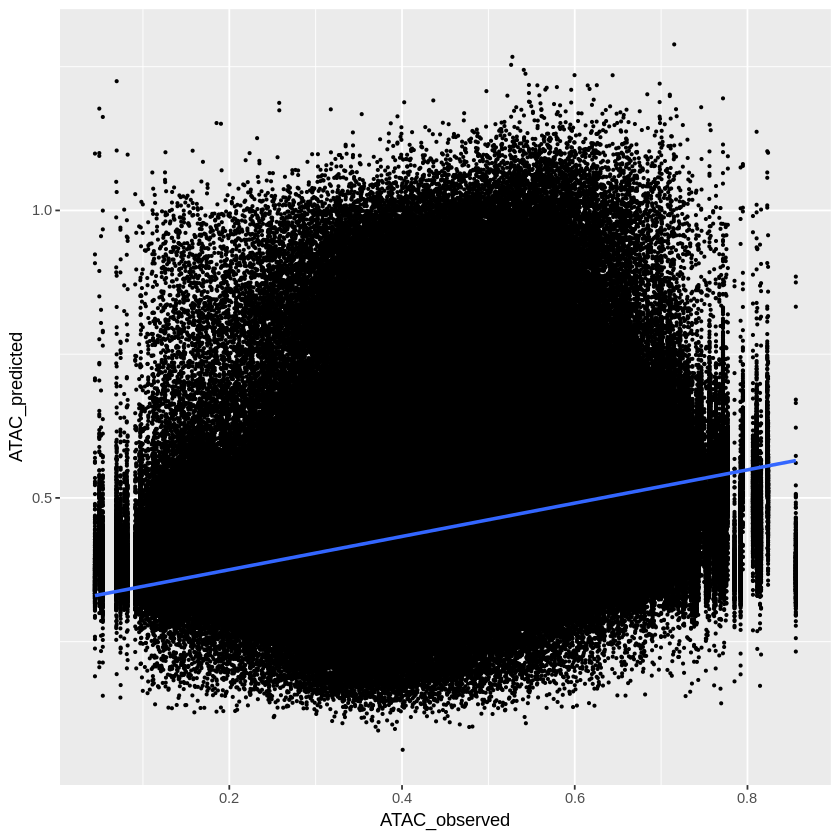

In [13]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

## Cor, MAE, RMSE -- all predictions

In [14]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

[1] 0.4110487

In [15]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.09040075

In [16]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.1202517

## Cor, MAE, RMSE -- 80% of the controls predictions

In [17]:
cor(pred_tibble_80_controls$ATAC_observed, pred_tibble_80_controls$ATAC_predicted)

[1] 0.5381332

In [18]:
ae    <- abs(pred_tibble_80_controls$ATAC_observed - pred_tibble_80_controls$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.08192365

In [19]:
se    <- (pred_tibble_80_controls$ATAC_observed - pred_tibble_80_controls$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.105532

## Cor, MAE, RMSE -- cases predictions

In [20]:
cor(pred_tibble_cases$ATAC_observed, pred_tibble_cases$ATAC_predicted)

[1] 0.352113

In [21]:
ae    <- abs(pred_tibble_cases$ATAC_observed - pred_tibble_cases$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.09755101

In [22]:
se    <- (pred_tibble_cases$ATAC_observed - pred_tibble_cases$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.1313916

## Save predictions

In [23]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])